In [1]:
from functools import reduce
from sklearn.decomposition import PCA
import cooler
import numpy as np
import pandas as pd
import bioframe
import bbi
from matplotlib import pyplot as plt
import glob
import os
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import LogLocator, ScalarFormatter, FormatStrFormatter, MultipleLocator
from matplotlib import ticker
import seaborn as sns
from yaml import load, dump, FullLoader
from natsort import natsorted
from cooltools.lib import numutils, plotting
from cooltools import saddle
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
os.chdir('/exports/igmm/eddie/wendy-lab/ilia/Rif1_clean_quaich/')

In [3]:
with open('config/config.yaml', 'r') as f:
    config = load(f, Loader=FullLoader)

In [4]:
samples = pd.read_csv(config['samples'], sep='\t')
coolers = {sample:cooler.Cooler(f'{path}::/resolutions/1000000') for i, sample, path in samples[['sample', 'file']].itertuples()}

colours = dict(zip(samples['sample'], samples['colour']))
groupcolours = dict(samples.groupby('group')['colour'].apply(lambda x: list(x)[0]))
groups = dict(samples.groupby('group')['sample'].apply(list))

In [5]:
expecteds = reduce(lambda left,right: pd.merge(left,right,on=['chrom', 'diag']),
                   (pd.read_csv(f'results/expected/{cond}_1000.expected.tsv', sep='\t').rename(columns={'balanced.sum':cond, 'n_valid':f'{cond}_valid'}).drop(['count.sum', 'balanced.avg', 'count.avg'], axis=1)
                    for cond in samples['sample'])).dropna()

In [6]:
sums = expecteds.groupby('diag').sum()
for cond in samples['sample']:
    sums[cond] = sums[cond]/sums[f'{cond}_valid']
    sums = sums.drop(columns=[f'{cond}_valid'])

sums['Distance'] = sums.index*1000
sums['Distance band'] = pd.cut(sums['Distance'], numutils.persistent_log_bins(bins_per_order_magnitude=4)[14:])
sums_grouped = sums.groupby('Distance band').sum().drop(['Distance'], axis=1)
sums_grouped[sums_grouped==0] = np.nan
sums_grouped = sums_grouped.dropna()

In [7]:
sums_long = sums_grouped.reset_index().melt(id_vars=['Distance band'], var_name='Sample', value_name='Interactions')
sums_long['Condition'] = sums_long['Sample'].str.split('_', expand=True)[0].str.split('-', expand=True)[1]
sums_long['Separation'] = sums_long['Distance band'].apply(lambda x: np.sqrt(x.left*x.right))
sums_long = sums_long.dropna()

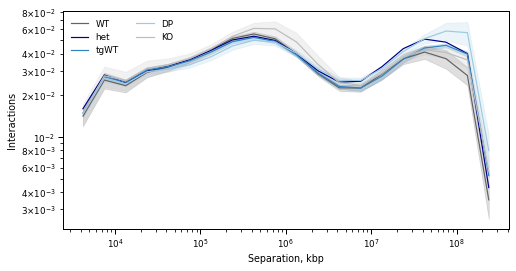

In [8]:
sns.set_context('paper')
f, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(x='Separation', y='Interactions', hue='Condition', data=sums_long, palette=groupcolours, ci='sd',
             hue_order=['WT', 'het', 'tgWT', 'DP', 'KO'], ax=ax)#, dodge=0.5)
ax.set(xscale='log', yscale='log')
ax.set_xlabel('Separation, kbp')
ax.legend(frameon=False, ncol=2)

class MathTextSciFormatter(ticker.Formatter):
    def __init__(self, fmt="%1.e", subs=(1, 2, 3, 4, 6, 8)):
        self.fmt = fmt
        self.subs = subs
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        if int(significand) not in self.subs:
            return ''
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            s =  r'%s%s' % (significand, exponent)
        return "${}$".format(s)

ax.yaxis.set_minor_formatter(MathTextSciFormatter())
ax.yaxis.set_minor_locator(ticker.LogLocator(subs=np.arange(10)))
plt.savefig(f'results/plots/interactions_vs_distance.pdf', bbox_inches='tight')

In [9]:
def format_ticks(ax, x=True, y=True, rotate=False):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

In [10]:
s, e = coolers['Rif1-WT_merged'].extent('chr11')
l = (e - s) * 1e6

In [11]:
def plot_heatmaps(toplot, filename):
    f, axarr = plt.subplots(2, len(toplot), dpi=300, figsize=(len(toplot)*2+1, 5), sharex=True, sharey=True)
    plt.setp(axarr[1, 0].spines.values(), visible=False)

    for i, name in enumerate(toplot):
        im = axarr[0, i].imshow(coolers[name].matrix(balance=True).fetch('chr11'), cmap='fall', norm=LogNorm(vmin=1e-4, vmax=1e-1), extent=[0, l, l, 0])
        axarr[0, i].set_title(name)
    axins = inset_axes(axarr[1, 0], width=0.1, height=1, loc='upper left')
    plt.colorbar(im, cax=axins)
    for i, name in enumerate(toplot):
        if i==0:
            continue
        im = axarr[1, i].imshow(coolers[name].matrix(balance=True).fetch('chr11')/coolers[toplot[0]].matrix(balance=True).fetch('chr11'),
                           cmap='coolwarm', norm=LogNorm(vmin=0.4, vmax=2.5), extent=[0, l, l, 0])
    axins = inset_axes(axarr[1, 0], width=0.1, height=1, loc='upper center')
    plt.colorbar(im, cax=axins)
    list(map(format_ticks, axarr.ravel()));
    axarr[1, 0].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
    plt.savefig(f'results/plots/{filename}')
    plt.close()

In [12]:
merged = ['Rif1-WT_merged', 'Rif1-KO_merged', 'Rif1-DP_merged', 'Rif1-tgWT_merged']
plot_heatmaps(merged, 'comparison.pdf')

In [13]:
wts = ['Rif1-WT_1', 'Rif1-WT_2', 'Rif1-WT_3']
plot_heatmaps(wts, 'WT_comparison.pdf')

In [14]:
nora = ['CTCF_Untreated', 'CTCF_AUX', 'CTCF_Washoff']
plot_heatmaps(nora, 'Nora_comparison.pdf')

In [15]:
rhodes = ['Tir1_AUX', 'Scc1_AUX', 'RING1B_AUX']
plot_heatmaps(rhodes, 'Rhodes_comparison.pdf')

In [16]:
res = 200000
nbins = 25
compartments = {cond:np.load(f'results/saddles/{cond}_{res}_{nbins}.saddledump.npz')['saddledata'][1:-1, 1:-1] for cond in samples['sample'][samples['sample'].str.startswith('Rif1')]}

In [17]:
def plot_saddles_cond(cols, data, norm=False, vmax=2, title='', filename=False):
    f = plt.figure(figsize=(len(cols)*2, 2.5), dpi=150)
    plt.suptitle(title)

    grid = ImageGrid(f, 111,  # similar to subplot(111)
                     nrows_ncols=(1, len(cols)),
                     axes_pad=0.1,
                     cbar_mode='single',
                     cbar_location='right',
                     share_all=False
                     )
    axarr = np.array(grid).reshape(1, len(cols))
    if type(norm)==int:
        norm = cols[norm]
    if norm is not False:
        ref = data[norm]
    for j, name in enumerate(cols):
        if norm is not False:
            d = data[name]/ref
        else:
            d = data[name]
        m = axarr[0, j].imshow(d, cmap='coolwarm', norm=LogNorm(vmin=1/vmax, vmax=vmax))
        axarr[0, j].set_xticks([])
        axarr[0, j].set_yticks([])
        axarr[0, j].set_title(name, size='small')
    cb = plt.colorbar(m, cax=grid.cbar_axes[0])
    cb.ax.tick_params(labelsize='x-small', which='both') 
    if filename:
        plt.savefig(f'results/plots/{filename}')

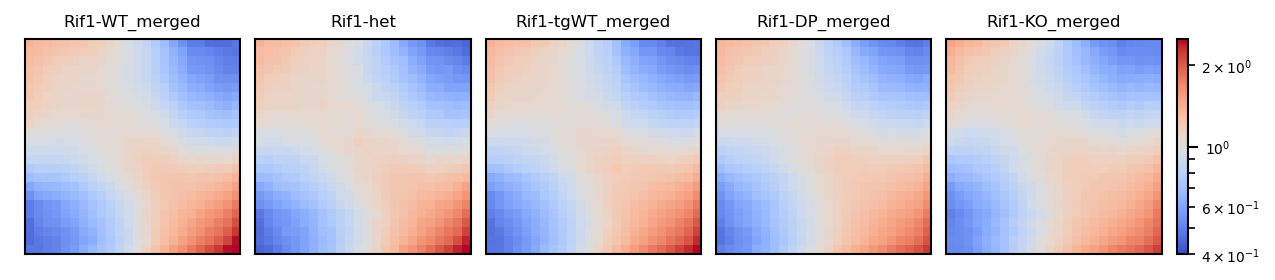

In [18]:
plot_saddles_cond(['Rif1-WT_merged', 'Rif1-het', 'Rif1-tgWT_merged', 'Rif1-DP_merged', 'Rif1-KO_merged'], compartments, vmax=2.5, filename='saddles.pdf')

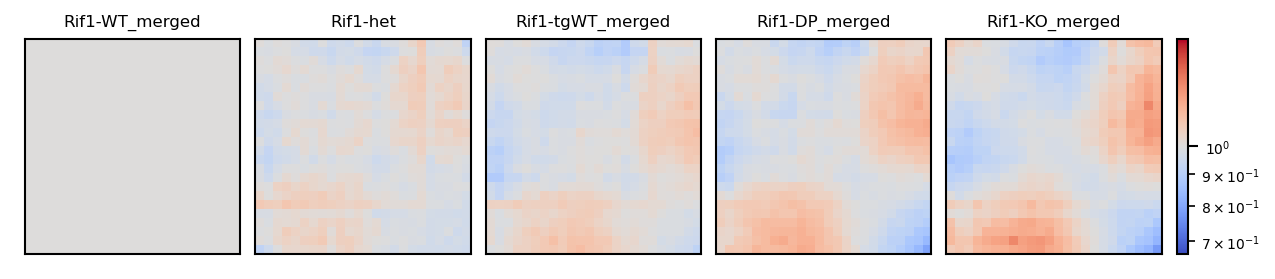

In [19]:
plot_saddles_cond(['Rif1-WT_merged', 'Rif1-het', 'Rif1-tgWT_merged', 'Rif1-DP_merged', 'Rif1-KO_merged'], compartments, norm=0, vmax=1.5, filename='saddles_norm.pdf')

In [20]:
rtb = bioframe.read_table("/exports/csce/datastore/biology/groups/buonomo/brutus/HiC/BigWig/mm10/RT/B_dedup_log2_EL_50kb.bedGraph", schema='bedGraph')
rtf = bioframe.read_table("/exports/csce/datastore/biology/groups/buonomo/brutus/HiC/BigWig/mm10/RT/F_dedup_log2_EL_50kb.bedGraph", schema='bedGraph')
rth = bioframe.read_table("/exports/csce/datastore/biology/groups/buonomo/brutus/HiC/BigWig/mm10/RT/H_dedup_log2_EL_50kb.bedGraph", schema='bedGraph')

In [21]:
bins = pd.read_csv("/exports/igmm/eddie/wendy-lab/ilia/genomes/mm10/bins/mm10_200000_bins.bed", sep='\t')

In [22]:
rt = pd.merge(rtb, rtf, on=['chrom', 'start', 'end'], suffixes=['_B', '_F']).merge(rth, on=['chrom', 'start', 'end']).rename(columns={'value':'value_H'})

In [23]:
rt.loc[:, ['value_B', 'value_F', 'value_H']] = rt.loc[:, ['value_B', 'value_F', 'value_H']].replace(0, np.nan)

In [24]:
rt['value'] = np.nanmean(rt.loc[:, ['value_B', 'value_F', 'value_H']], axis=1)

<ipython-input-24-a0d747b1cc4e>:1: RuntimeWarning: Mean of empty slice
  rt['value'] = np.nanmean(rt.loc[:, ['value_B', 'value_F', 'value_H']], axis=1)


In [25]:
rt = rt[['chrom', 'start', 'end', 'value']]

In [26]:
rt = bioframe.overlap(bins, rt, how='left', suffixes=['', '_rt']).drop(columns=['chrom_rt', 'start_rt', 'end_rt'])
rt['value_rt'] = pd.to_numeric(rt['value_rt'], errors='coerce')
rt = rt.groupby(['chrom', 'start', 'end']).mean().reset_index()

In [27]:
qlo, qhi = 0.01, 0.99
q_edges = np.linspace(qlo, qhi, 25)
binedges = saddle.quantile(rt['value_rt'], q_edges)

In [28]:
track = rt
track_name = 'value_rt'
digitized, hist = saddle.digitize_track(
    binedges, track=(rt, 'value_rt'),
)
regions = bioframe.fetch_chromsizes('mm10', as_bed=True)
regions['name'] = regions['chrom']

In [29]:
rtsaddles = {}
for sample in merged+['Rif1-het']:
    expected = pd.read_csv(f'results/expected/{sample}_200000.expected.tsv', sep='\t').rename(columns={'chrom':'region'})
    coolfile = f'{samples[samples["sample"]==sample]["file"].values[0]}::resolutions/200000'
    getmatrix = saddle.make_cis_obsexp_fetcher(
            cooler.Cooler(coolfile), (expected, 'balanced.avg'), weight_name='weight'
        )
    S, C = saddle.make_saddle(
    getmatrix,
    binedges,
    (digitized, track_name + ".d"),
    contact_type='cis',
    regions=regions)

    rtsaddles[sample] = (S / C)[1:-1, 1:-1]

/exports/igmm/eddie/wendy-lab/ilia/condaenvs/Rif1/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/exports/igmm/eddie/wendy-lab/ilia/condaenvs/Rif1/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/exports/igmm/eddie/wendy-lab/ilia/condaenvs/Rif1/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/exports/igmm/eddie/wendy-lab/ilia/condaenvs/Rif1/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/exports/igmm/eddie/wendy-lab/ilia/condaenvs/Rif1/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/exports/igmm/eddie/wendy-lab/ilia/condaenvs/Rif1/lib/python3.8/s

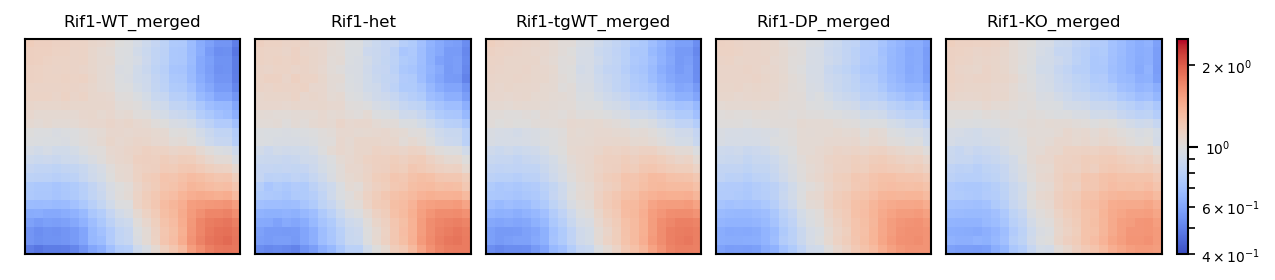

In [30]:
plot_saddles_cond(['Rif1-WT_merged', 'Rif1-het', 'Rif1-tgWT_merged', 'Rif1-DP_merged', 'Rif1-KO_merged'], rtsaddles, vmax=2.5, filename='RT_saddles.pdf')

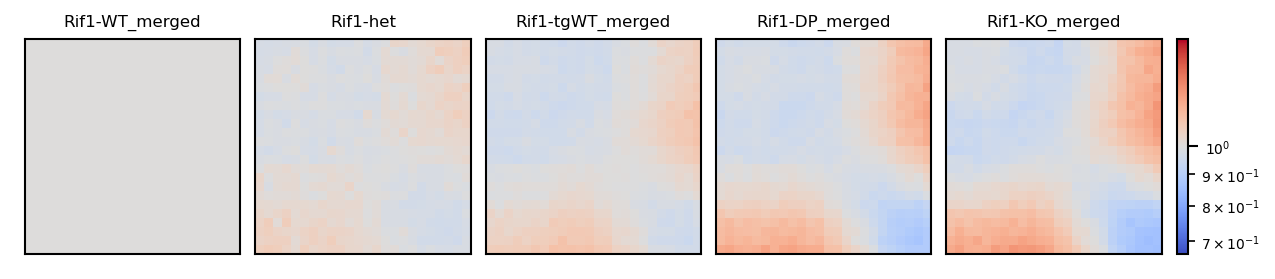

In [31]:
plot_saddles_cond(['Rif1-WT_merged', 'Rif1-het', 'Rif1-tgWT_merged', 'Rif1-DP_merged', 'Rif1-KO_merged'], rtsaddles, norm=0, vmax=1.5, filename='RT_saddles_norm.pdf')

In [32]:
chip = bins.copy()

In [33]:
with bbi.open('inputs/11_log2_ChIP_IN.bw') as f:
    chip['value_11'] = chip.apply(lambda x: (f.fetch(x['chrom'], x['start'], x['end'], bins=1)[0]), axis=1)
with bbi.open('inputs/12_log2_ChIP_IN.bw') as f:
    chip['value_12'] = chip.apply(lambda x: (f.fetch(x['chrom'], x['start'], x['end'], bins=1)[0]), axis=1)
with bbi.open('inputs/16_log2_ChIP_IN.bw') as f:
    chip['value_16'] = chip.apply(lambda x: (f.fetch(x['chrom'], x['start'], x['end'], bins=1)[0]), axis=1)

In [34]:
chip.loc[:, ['value_11', 'value_12', 'value_16']] = chip.loc[:, ['value_11', 'value_12', 'value_16']].replace(0, np.nan)

In [35]:
chip['value'] = np.nanmean(chip.loc[:, ['value_11', 'value_12', 'value_16']], axis=1)
chip = chip[['chrom', 'start', 'end', 'value']]

<ipython-input-35-c593ed04a671>:1: RuntimeWarning: Mean of empty slice
  chip['value'] = np.nanmean(chip.loc[:, ['value_11', 'value_12', 'value_16']], axis=1)


In [36]:
binedges = saddle.quantile(chip['value'], q_edges)

In [37]:
track = chip
track_name = 'value'
digitized, hist = saddle.digitize_track(
    binedges, track=(chip, track_name),
)

In [38]:
chipsaddles = {}
for sample in merged+['Rif1-het']:
    expected = pd.read_csv(f'results/expected/{sample}_200000.expected.tsv', sep='\t').rename(columns={'chrom':'region'})
    coolfile = f'{samples[samples["sample"]==sample]["file"].values[0]}::resolutions/200000'
    getmatrix = saddle.make_cis_obsexp_fetcher(
            cooler.Cooler(coolfile), (expected, 'balanced.avg'), weight_name='weight'
        )
    S, C = saddle.make_saddle(
    getmatrix,
    binedges,
    (digitized, track_name + ".d"),
    contact_type='cis',
    regions=regions)

    chipsaddles[sample] = (S / C)[1:-1, 1:-1]

/exports/igmm/eddie/wendy-lab/ilia/condaenvs/Rif1/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/exports/igmm/eddie/wendy-lab/ilia/condaenvs/Rif1/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/exports/igmm/eddie/wendy-lab/ilia/condaenvs/Rif1/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/exports/igmm/eddie/wendy-lab/ilia/condaenvs/Rif1/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/exports/igmm/eddie/wendy-lab/ilia/condaenvs/Rif1/lib/python3.8/site-packages/cooltools/saddle.py:146: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/exports/igmm/eddie/wendy-lab/ilia/condaenvs/Rif1/lib/python3.8/s

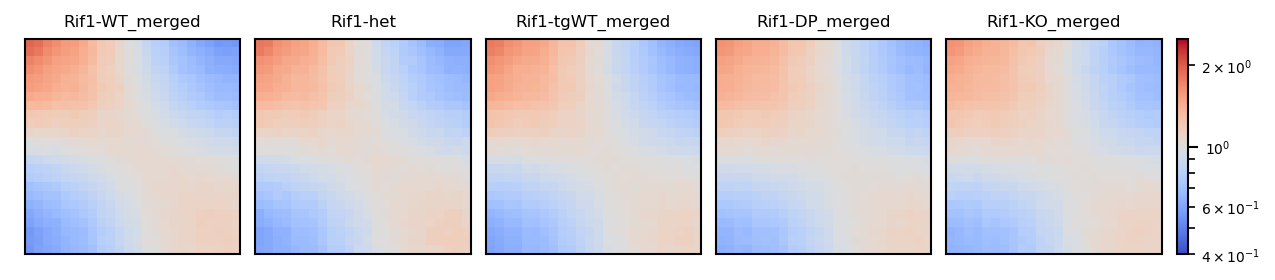

In [39]:
plot_saddles_cond(['Rif1-WT_merged', 'Rif1-het', 'Rif1-tgWT_merged', 'Rif1-DP_merged', 'Rif1-KO_merged'], chipsaddles, vmax=2.5, filename='Rif1_saddles.pdf')

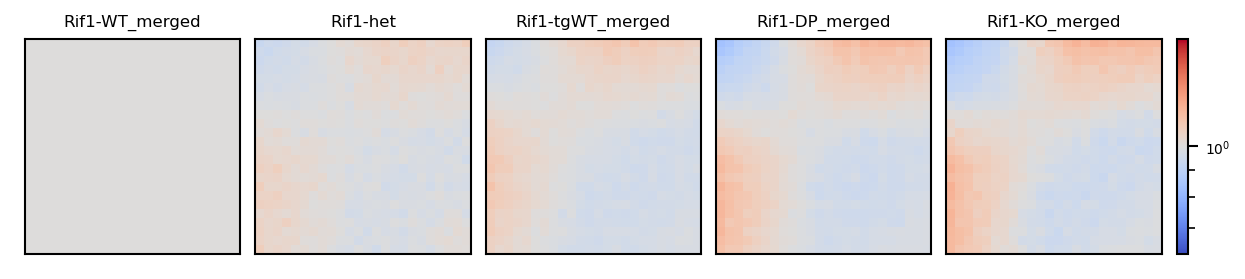

In [40]:
plot_saddles_cond(['Rif1-WT_merged', 'Rif1-het', 'Rif1-tgWT_merged', 'Rif1-DP_merged', 'Rif1-KO_merged'], chipsaddles, norm=0, vmax=1.6, filename='Rif1_saddles_norm.pdf')

In [41]:
eigs = [pd.read_csv(f'results/eigenvectors/%s_200000_eigenvectors.cis.vecs.tsv' % cond, sep='\t') for cond in samples['sample']]
for i, (eig, sample) in enumerate(zip(eigs, samples['sample'])):
    eigs[i] = eig.rename(columns={'E1':'%s' % sample}).drop(['weight', 'E2', 'E3'], axis=1)
alleigreps = reduce(lambda left,right: pd.merge(left,right,on=['chrom', 'start', 'end', 'GC']), eigs)

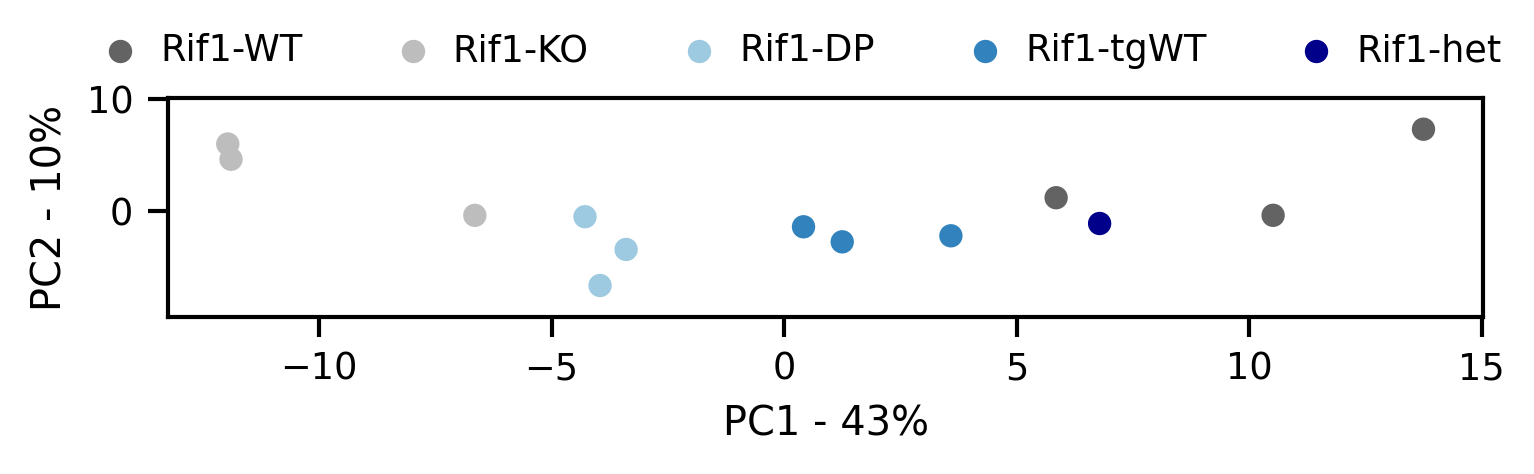

In [42]:
conditions = samples['sample'][(samples['sample'].str.startswith('Rif1')) & (~samples['sample'].str.endswith('merged'))]
pca = PCA(6)
data_pca = pd.DataFrame(pca.fit_transform(alleigreps[conditions].dropna().T), index=conditions)

f, ax = plt.subplots(figsize=(5, 1.5), constrained_layout=True, dpi=300)
ax.set_aspect(pca.explained_variance_[1]/pca.explained_variance_[0])
ax.scatter(data_pca[0], data_pca[1], c=[colours[cond] for cond in conditions], label='_')
for cond in merged:
    ax.scatter([], [], c=colours[cond], label=cond.split('_')[0])
ax.scatter([], [], c=colours['Rif1-het'], label='Rif1-het')
plt.margins(0.05, 0.2)
ax.set_xlabel('PC1 - {0}%'.format(int(round(pca.explained_variance_ratio_[0], 2)*100)))
ax.set_ylabel('PC2 - {0}%'.format(int(round(pca.explained_variance_ratio_[1], 2)*100)))
f.legend(loc='upper right', ncol=5, handletextpad=0.1, frameon=False)

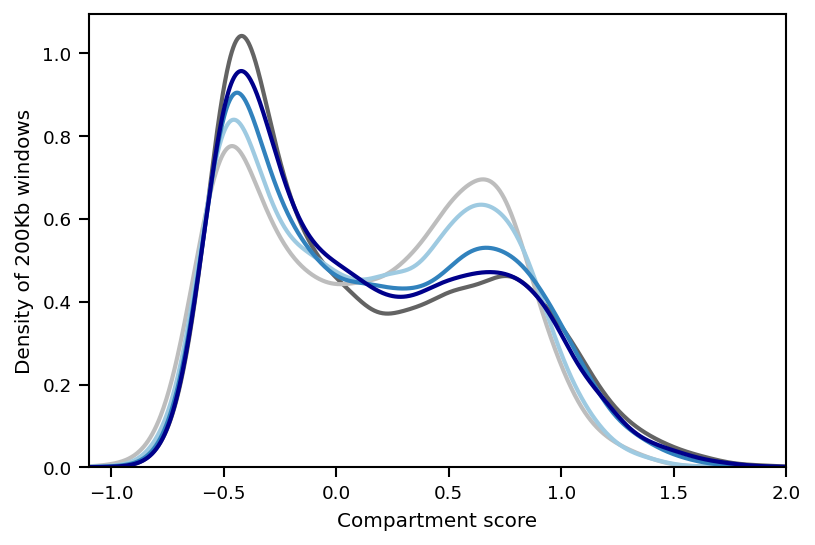

In [43]:
f, ax = plt.subplots(dpi=150)
for cond in merged+['Rif1-het']:
    sns.kdeplot(alleigreps[cond], ax=ax, color=colours[cond], gridsize=1000, clip=(-1.1, 2), lw=2)
ax.set_xlim(-1.1, 2)
ax.set_ylabel('Density of 200Kb windows')
ax.set_xlabel('Compartment score')
plt.savefig('results/plots/eigenvector_density.pdf')

In [44]:
def group_bydist(data, grouping=groups):
    newdata = {}
    for mindist in data.keys():
        newdata[mindist] = {}
        newdata[mindist] = {cond:np.nanmean([data[mindist][gen] for gen in grouping[cond]], axis=0) for cond in grouping.keys()}
    return newdata

In [45]:
saddle_mindist, saddle_maxdist = config["saddle"]["distance_limits"]
saddle_mindists = [
    int(saddle_mindist * 2 ** i)
    for i in np.arange(0, np.log2(saddle_maxdist / saddle_mindist))
]
saddle_separations = [f"_dist_{mindist}-{mindist*2}" for mindist in saddle_mindists]

In [46]:
res = 200000
bins = 100

saddles_dict = {}

def mult_saddle(file):
    d = np.load(file)
    return (d['saddledata'])[1:-1, 1:-1]

for mindist in saddle_mindists:
    saddles_dict[mindist] = {cond:mult_saddle(f'results/saddles/{cond}_{res}_{bins}_dist_{mindist}-{mindist*2}.saddledump.npz') for cond in samples[~samples['sample'].str.endswith('merged')].dropna()['sample']}

In [47]:
def get_corner_means(arr, i=5):
    tl = np.nanmean(arr[:i, :i])
    tr = np.nanmean(arr[-i:, :i])
    br = np.nanmean(arr[-i:, -i:])
    bl = np.nanmean(arr[:i, -i:])
    return tl, br, tr, bl

def comp_strength(arr, i=10):
    tl, br, tr, bl = get_corner_means(arr, i)
    return (tl + br) / (tr + bl)

In [48]:
saddles = pd.DataFrame(saddles_dict).reset_index().rename(columns={'index':'sample'}).melt(id_vars=['sample'], var_name='mindist', value_name='saddle')
saddles['Strength'] = saddles['saddle'].apply(comp_strength)
saddles['Distance, Mbp'] = (saddles['mindist']//1000000).apply(lambda x: (x, x*2))

In [49]:
saddles = saddles.merge(samples[['sample', 'group']])

/exports/igmm/eddie/wendy-lab/ilia/condaenvs/Rif1/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


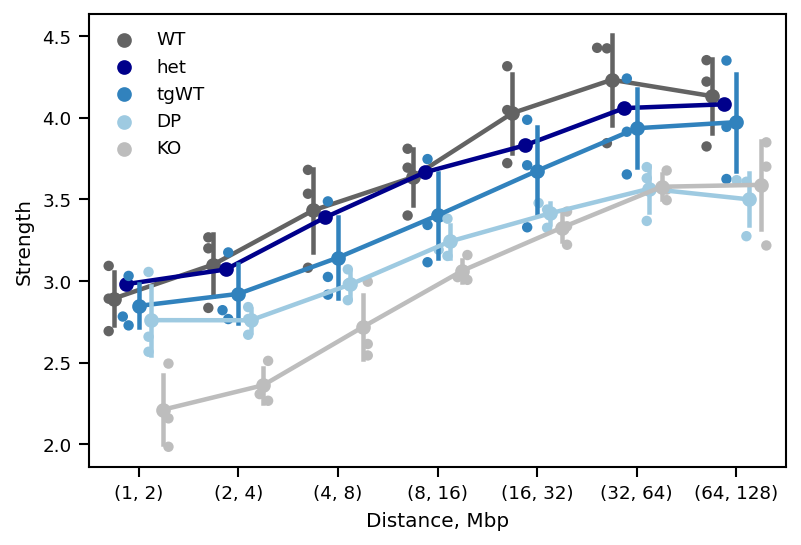

In [50]:
sns.set_context('paper')
f, ax = plt.subplots(dpi=150)
sns.pointplot(x='Distance, Mbp', y='Strength', hue='group', ci='sd',
               hue_order=['WT', 'het', 'tgWT', 'DP', 'KO'], join=True, dodge=0.5, palette=groupcolours,
               data=saddles, ax=ax)
sns.swarmplot(x='Distance, Mbp', y='Strength', hue='group',
               hue_order=['WT', 'tgWT', 'DP', 'KO'], dodge=0.5, palette=groupcolours,
               data=saddles, ax=ax)
h,l = ax.get_legend_handles_labels()
ax.legend_.remove()
ax.legend(h[:5], l[:5], frameon=False)
plt.savefig('results/plots/Compartment_strength_by_distance.pdf')